In [43]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.base import BaseEstimator, clone
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import (
    confusion_matrix, f1_score, precision_recall_curve, precision_score, 
    recall_score, roc_auc_score, roc_curve)
from sklearn.model_selection import (
    cross_val_predict, cross_val_score, StratifiedKFold)
from sklearn.multiclass import OneVsOneClassifier
from sklearn.preprocessing import StandardScaler

In [2]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
X, y = mnist['data'], mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

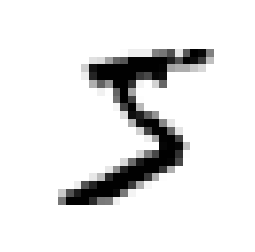

In [4]:
some_digit = X[0]
some_digit_img = some_digit.reshape(28, 28)
plt.imshow(some_digit_img, cmap=mpl.cm.binary, interpolation='nearest')
plt.axis('off');

In [5]:
y[0]

'5'

In [6]:
y = y.astype(np.uint)

In [7]:
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

# Training a Binary Classifier

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [9]:
sgd_clf = SGDClassifier(random_state=1103)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=1103, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [10]:
sgd_clf.predict([some_digit])

array([ True])

In [11]:
skfolds = StratifiedKFold(n_splits=3, random_state=1103)
for train_idx, test_idx in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_idx]
    y_train_folds = y_train_5[train_idx]
    X_test_fold = X_train[test_idx]
    y_test_fold = y_train_5[test_idx]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.96535
0.96465
0.96355


In [12]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.96535, 0.96465, 0.96355])

In [13]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [15]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [16]:
confusion_matrix(y_train_5, y_train_pred)

array([[53625,   954],
       [ 1175,  4246]])

In [17]:
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))
print(f1_score(y_train_5, y_train_pred))

0.8165384615384615
0.7832503228186681
0.7995480651539403


In [18]:
y_scores = cross_val_predict(
    sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [19]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, 
                                                         y_scores)

In [20]:
def plot_precision_recall(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g', label='Recall')

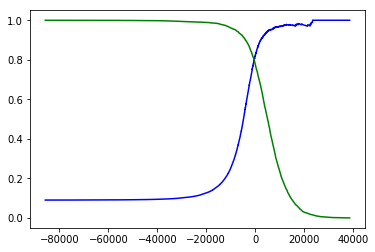

In [21]:
plot_precision_recall(precisions, recalls, thresholds)

In [22]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, lw=2, label=label)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    if label is not None:
        plt.legend()

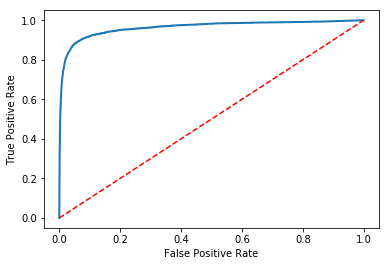

In [23]:
fpr, tpr, throsholds = roc_curve(y_train_5, y_scores)
plot_roc_curve(fpr, tpr)

In [24]:
roc_auc_score(y_train_5, y_scores)

0.9631676635698659

In [25]:
forest_clf = RandomForestClassifier(random_state=1111)
y_probs_forest = cross_val_predict(
    forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [26]:
y_scores_forest = y_probs_forest[:, 1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, 
                                                     y_scores_forest)

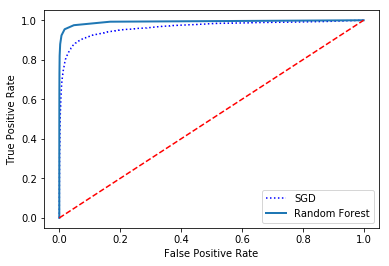

In [27]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')

In [28]:
roc_auc_score(y_train_5, y_scores_forest)

0.9922425774925767

# Multiclass Classification

In [30]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=uint64)

In [31]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-10470.61255603, -28468.92376779,  -8627.99655021,
          1378.21500433, -22343.89741475,   4879.62441378,
        -25334.71251568, -19147.93148547, -17819.55452442,
        -14425.3416898 ]])

In [32]:
print(np.argmax(some_digit_scores))
print(sgd_clf.classes_[5])

5
5


In [35]:
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=1123))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint64)

In [36]:
len(ovo_clf.estimators_)

45

In [40]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([5], dtype=uint64)

In [41]:
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0.1, 0. , 0. , 0.8, 0. , 0. , 0.1, 0. ]])

In [42]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.88607279, 0.85374269, 0.87873181])

In [44]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.89947011, 0.90079504, 0.89688453])

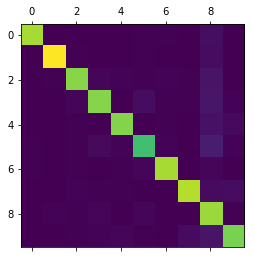

In [49]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
plt.matshow(conf_mx);

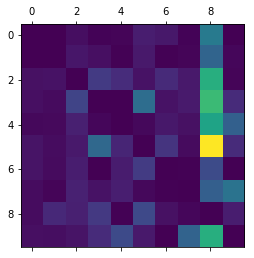

In [48]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx);